# TP4 : ABR (Tahar AMAIRI & Corentin POMMELEC)

In [1]:
# import libs
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(0)

## Load the data

In [2]:
# The JSON file is very big (~ 10 GB), so it will be loaded as chunks
with pd.read_json('./Books.json', lines=True, chunksize=100000) as jsonChunks:
    dfAll = pd.DataFrame() # data frame containing all the ratings
    
    # read each chunk
    for chunk in jsonChunks:
       
        # concatenate to the dfAll data frame
        dfAll = pd.concat([dfAll, chunk.loc[:,['reviewerID','asin','overall']]], axis=0) 

dfAll = dfAll.copy() # de-fragmented the data frame for better performance

## a) Construct the reviewer - book matrix 

,Percentage of non zero value
0439023483,12.162162
0143170090,9.049959
0439023513,7.944308
0141039280,7.780508
030758836X,7.534808
...,...
1615190619,0.040950
1782991034,0.040950
1456406272,0.040950
1477848967,0.040950


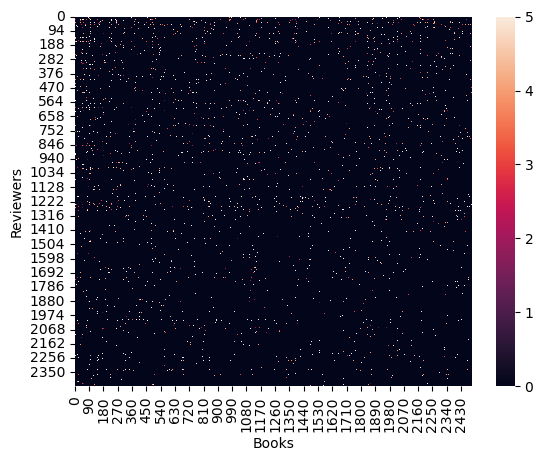

In [3]:
def getFr1(dfAll, n, p):
    books = dfAll['asin'].value_counts().index[0:p]
    reviewers = dfAll['reviewerID'].value_counts().index[0:n]

    dfSorted = dfAll[dfAll['asin'].isin(books)]
    dfSorted = dfSorted[dfSorted['reviewerID'].isin(reviewers)]

    Fr1 = pd.DataFrame(data=0, columns=books, index=reviewers, dtype='int8')
    byAsin = dfSorted.groupby("asin")

    for asin, frame in byAsin:
        Fr1.loc[frame["reviewerID"], asin] =+ frame["overall"].to_numpy()

    Fr1 = Fr1.loc[:,(Fr1 != 0).any(axis=0)]
    Fr1 = Fr1.loc[(Fr1 != 0).any(axis=1),:]

    return Fr1

def plotHeatMap(Fr1, xLabel = 'Books', yLabel = 'Reviewers', title=''):
    tmp = Fr1.copy()
    tmp.columns = list(range(tmp.shape[1]))
    tmp.index = list(range(tmp.shape[0]))
    plt.title(title)
    sns.heatmap(tmp).set(xlabel=xLabel, ylabel=yLabel);

def plotStats(Fr1):
    s = (Fr1.astype(bool).sum().sort_values(ascending=False) / Fr1.shape[0]) * 100
    df = pd.DataFrame(s, columns=["Percentage of non zero value"])
    display(df)

Fr1 = getFr1(dfAll, 2500, 2500)
plotHeatMap(Fr1)
plotStats(Fr1)

,Percentage of non zero value
1476755590,88.235294
0615748996,88.235294
0062294776,82.352941
0989450201,82.352941
1476776016,82.352941
0451468279,76.470588
1483966763,76.470588
1492121169,76.470588
006230240X,76.470588
1476718202,76.470588


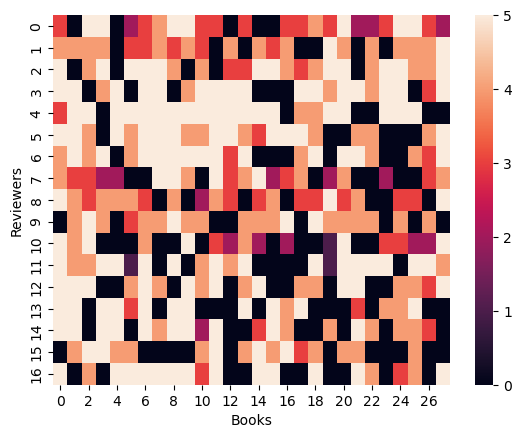

In [4]:
def getDenseSubMatrix(Fr1, r, std, minN, minP):
    while(1):
        Fr1 = Fr1.loc[(Fr1 == 0).sum(axis=1).sort_values().index,:]
        Fr1 = Fr1[(Fr1 == 0).sum().sort_values().index]
    
        if(Fr1.shape[0] - r < minN and Fr1.shape[1] - r < minP):
            break
        elif(Fr1.shape[0] - r < minN):
            Fr1 = Fr1.iloc[:,0:minP]
            break
        elif(Fr1.shape[1] - r < minP):
            Fr1 = Fr1.iloc[0:minN,:]
            break

        Fr1 = Fr1.iloc[0:(Fr1.shape[0] - r),0:(Fr1.shape[1] - r)]
        Fr1 = Fr1.loc[:,(Fr1 != 0).any(axis=0)]
        Fr1 = Fr1.loc[(Fr1 != 0).any(axis=1),:]
    
    Fr1 = Fr1.loc[Fr1.T.replace(to_replace = 0, value = np.nan).std() > std,:]
    Fr1 = Fr1.loc[:, Fr1.replace(to_replace = 0, value = np.nan).std() > std]
    return Fr1

Fr1 = getDenseSubMatrix(Fr1, 1, 0.5, 30, 30)
plotHeatMap(Fr1) 
plotStats(Fr1)

## b) Get train dataset

In [5]:
def dataSelection(Fr1, hideNumber, verbose = False):
    L = list()
    idx = list()
    hiddenRatings = list()

    for _, r in Fr1.iterrows():
        idx.append(np.nonzero(r.values)[0])

    for i in range(3):
        tmp = Fr1.copy()
        hDict = dict()

        for c, arr in enumerate(idx):
            size = len(arr)
            h = hideNumber if size > hideNumber else size
            mask = np.random.choice(arr,h,replace=False)
            hDict[c] = mask, tmp.iloc[c,:][mask].values
            tmp.iloc[c,:][mask] = 0

        if verbose:
            print("Dataset {}".format(i+1))
            plotStats(tmp)

        L.append(tmp)
        hiddenRatings.append(hDict)

    return L, hiddenRatings

trainSet, hiddenRatings = dataSelection(Fr1, 2, True)

Dataset 1


,Percentage of non zero value
0615748996,82.352941
0989450201,82.352941
0062294776,76.470588
1476776016,76.470588
1476718202,76.470588
1476755590,70.588235
1492121169,70.588235
1455548987,70.588235
006230240X,70.588235
148234873X,70.588235


Dataset 2


,Percentage of non zero value
0062294776,82.352941
0615748996,82.352941
0989450201,82.352941
1483966763,76.470588
1455548987,76.470588
1492121169,76.470588
006230240X,76.470588
0988695103,76.470588
1476755590,70.588235
1476776016,70.588235


Dataset 3


,Percentage of non zero value
1476755590,88.235294
0615748996,88.235294
1476776016,82.352941
0989450201,76.470588
0062294776,76.470588
0988695103,76.470588
061579615X,70.588235
1476712980,70.588235
1476718202,70.588235
1480536466,70.588235


## c) Pearson correlation

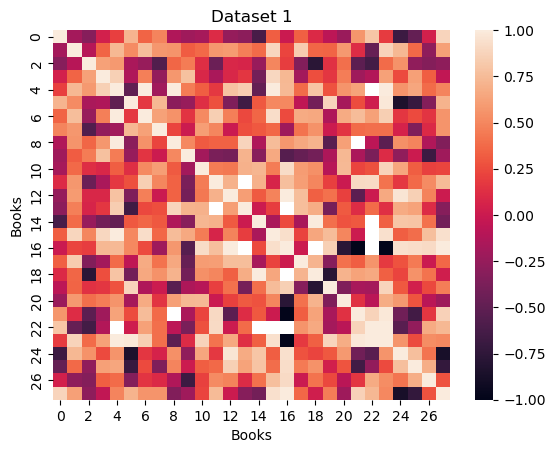

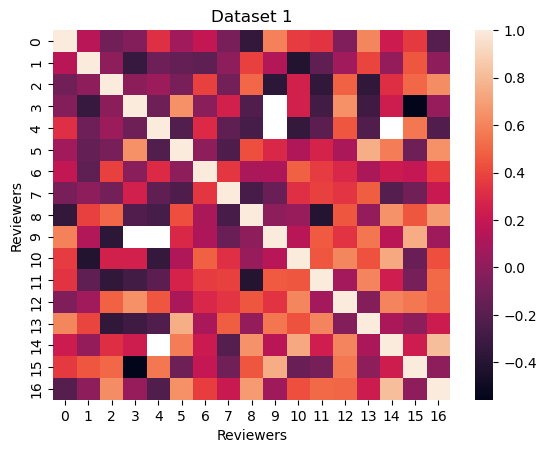

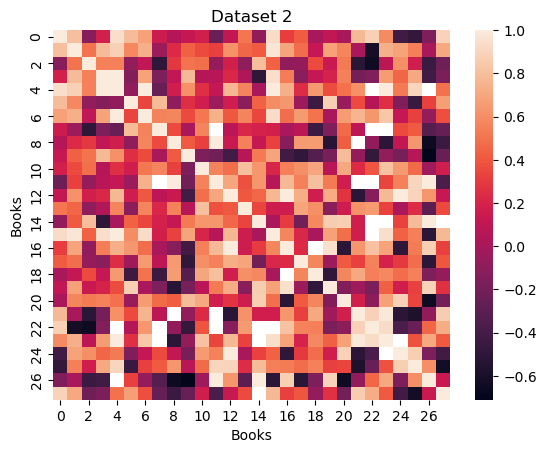

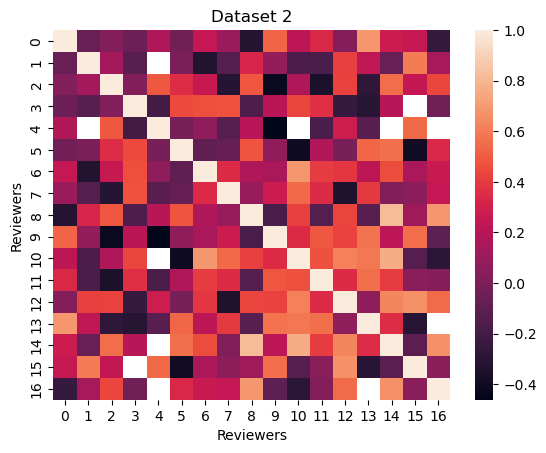

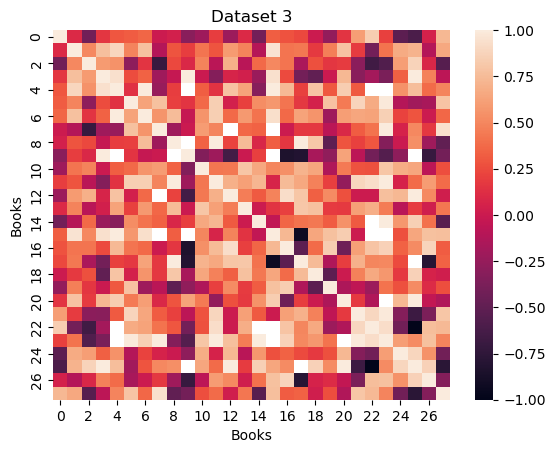

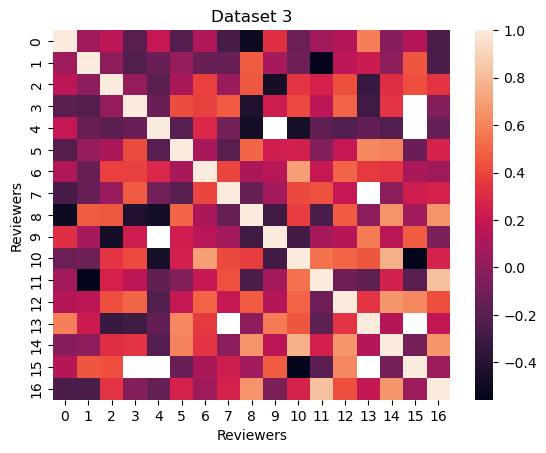

<Figure size 640x480 with 0 Axes>

In [6]:
listPearsonSimBooks = list()
listPearsonSimUsers = list()

for i, Fr2 in enumerate(trainSet):
    tmp = Fr2.copy()
    tmp.replace(to_replace = 0, value = np.nan, inplace=True)
    listPearsonSimBooks.append(tmp.corr(method='pearson'))
    listPearsonSimUsers.append(tmp.T.corr(method='pearson'))
    plotHeatMap(listPearsonSimBooks[-1], xLabel='Books', yLabel='Books', title ="Dataset {}".format(i+1))
    plt.figure()
    plotHeatMap(listPearsonSimUsers[-1], xLabel='Reviewers', yLabel='Reviewers', title ="Dataset {}".format(i+1))
    plt.figure()

In [7]:
def extractMostSimilarElements(dfPearsonSim, nMostSimilar):
    dictEl = dict()
    for col in dfPearsonSim.columns:
        s = dfPearsonSim.sort_values(col,ascending=False)[col]
        dictEl[col] = s.index[1:nMostSimilar].tolist(), s.values[1:nMostSimilar].tolist()
    return dictEl

listU = list()
listI = list()

for simBooks in listPearsonSimBooks:
    listI.append(extractMostSimilarElements(simBooks, 4))
for simUsers in listPearsonSimUsers:
    listU.append(extractMostSimilarElements(simUsers, 9))

def checkNaNPresence(listElement):
    for d in listElement:
        for k,v in d.items():
            if np.isnan(v[1]).sum():
                return True

    return False

assert(checkNaNPresence(listI) == False)
assert(checkNaNPresence(listU) == False)

## d) Ratings prediction
### ii) Estimate W for each train set

In [8]:
def computeAllZSum(Fr, I, U):
    AllZSum = list()

    for i, reviewer in enumerate(Fr.index):
        AllZSum.append(list())
        AllZ = list()

        for book in Fr.columns:
            for simBook in I[book][0]:
                Z = np.zeros((5,8))
                for k, simReviewer in enumerate(U[reviewer][0]):
                    rij = Fr.loc[simReviewer,simBook]
                    if rij :
                        Z[rij-1, k] = rij
                AllZ.append(Z)

            AllZSum[i].append(np.sum(AllZ, axis=0))

    return AllZSum
            
def computeLossGradient(Fr, W, AllZSum):
    n, p = Fr.shape[0] , Fr.shape[1]
    countP, countN = 0, 0
    S = np.zeros(5)
    
    for i in range(n):
        for j in range(p):
            rij = Fr.iloc[i,j]
            if rij:
                ZSum = AllZSum[i][j]
                prod = W @ ZSum
                R = np.linalg.norm(W @ ZSum)
                sign = 1 if R - rij > 0 else -1
                S =+ ((ZSum @ prod) / R) * sign
                countP += 1

        if True in Fr.iloc[i,:].astype(bool).values:
            countN += 1

    return S / (countN * countP)

def gradientDescent(Fr, I, U, maxIter = 5000, eta = 0.001):
    W = np.random.uniform(0, 5.0, 5)
    AllZSum = computeAllZSum(Fr, I, U)

    for _ in range(maxIter):
        W = W - eta * computeLossGradient(Fr, W, AllZSum)
       
    return W

listW = list()

for i in range(3):
    listW.append(gradientDescent(trainSet[i], listI[i], listU[i]))

### iii) Predict hidden ratings

In [13]:
def predict(Fr, I, U, W, ratings):
    AllZSum = computeAllZSum(Fr, I, U)
    pred = list()
   
    for i, t in ratings.items():
        mask = t[0]
        for j in mask:
            ZSum = AllZSum[i][j]
            R = np.linalg.norm(W @ ZSum)
            R = R if R < 5.0 else 5.0
            pred.append(np.ceil(R))

    return pred
            
listPred = list()

for i in range(3):
    listPred.append(predict(trainSet[i], listI[i], listU[i], listW[i], hiddenRatings[i]))

### iv) Compute errors

,Accuracy,RMSE,MAE
Test1,0.558824,0.882353,0.588235
Test2,0.411765,1.352941,0.823529
Test3,0.411765,1.441176,0.794118


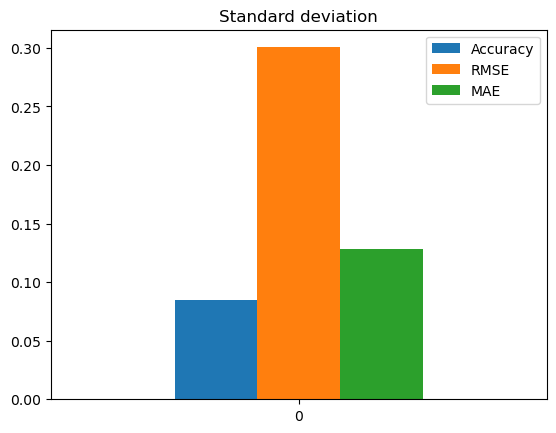

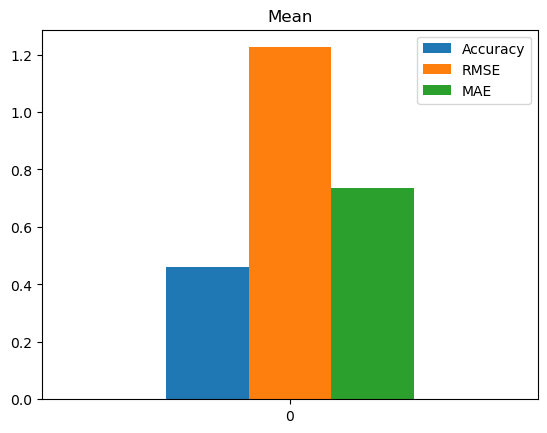

In [14]:
from sklearn import metrics

def getErrors(listPred, hiddenRatings):
    trueR = list()

    for k, trueRatings in enumerate(hiddenRatings):
        trueR.append(list())
        for i, t in trueRatings.items():
            r = t[1]
            for j in r:
                trueR[k].append(j)

    err = list()

    for i in range(3):
        MSE = metrics.mean_squared_error(trueR[i],listPred[i])
        MAE = metrics.mean_absolute_error(trueR[i],listPred[i])
        acc = metrics.accuracy_score(trueR[i],listPred[i])
        err.append([acc,MSE,MAE])

    df = pd.DataFrame(data=err, columns=['Accuracy','RMSE','MAE'], index=['Test1','Test2','Test3'])
    std = pd.DataFrame(df.std()).T
    mean = pd.DataFrame(df.mean()).T

    display(df)
    std.plot.bar(rot=0,title='Standard deviation')
    mean.plot.bar(rot=0,title='Mean')

getErrors(listPred, hiddenRatings)